In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def generate_X_y(n_samples=1000, random_state=42):

    A = np.random.normal(0, 1, n_samples)
    B = np.random.normal(0, 1, n_samples)
    C = np.random.normal(0, 1, n_samples)

    X1 = A + np.random.normal(0, 1, n_samples)
    X2 = B + np.random.normal(0, 1, n_samples)
    X3 = C + np.random.normal(0, 1, n_samples)

    X4 = A + B + np.random.normal(0, 1, n_samples)
    X5 = B + C + np.random.normal(0, 1, n_samples)
    X6 = A + C + np.random.normal(0, 1, n_samples)

    y = X1 + X3 + np.random.normal(0, 1, n_samples)

    dataset = pd.DataFrame({
        'X1': X1,
        'X2': X2,
        'X3': X3,
        'X4': X4,
        'X5': X5,
        'X6': X6,
        'y': y
    })

    X = dataset.iloc[:,:-1]
    y = dataset.iloc[:,-1]

    return X, y


In [3]:
X, y = generate_X_y(500)
print(X.shape, y.shape)

(500, 6) (500,)


[]


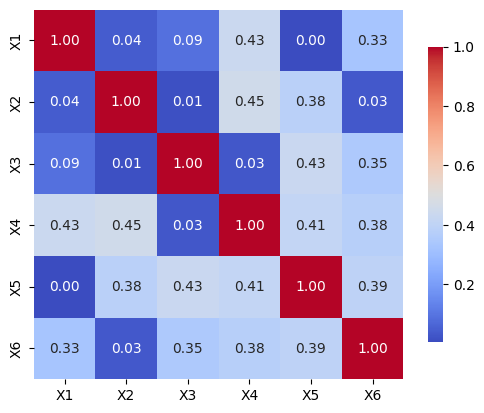

In [4]:
# Selecting features with high mutual correlations to drop - not the best solution!

feat_to_drop = []
corr = X.corr().abs()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar_kws={'shrink': .8, 'orientation': 'vertical'})
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool_))
feats_to_drop = [col for col in upper.columns if any(upper[col] > 0.9)]
print(feats_to_drop)

# Implement Variance Inflation Factor (VIF) Analysis

In [5]:

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [6]:

def calculate_vif(X):
    """
    Calculate VIF for each feature in the dataset
    
    Parameters:
    - X: DataFrame of numeric features
    
    Returns:
    - DataFrame with VIF values for each feature
    """
    # Create a DataFrame to store VIF values
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    
    # Calculate VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    # Sort by VIF value
    vif_data = vif_data.sort_values("VIF", ascending=False)
    
    return vif_data

In [7]:

def handle_multicollinearity_vif(X, threshold=10.0):
    """
    Handle multicollinearity using VIF method
    
    Parameters:
    - X: DataFrame of numeric features
    - threshold: VIF threshold above which to consider a feature as problematic
    
    Returns:
    - DataFrame with problematic features removed
    """
    # Make a copy of the data
    X_new = X.copy()
    
    # Keep track of removed features
    removed_features = []
    
    # Calculate initial VIF values
    vif = calculate_vif(X_new)
    print("Initial VIF values:\n", vif)
    
    # Plot initial VIF values
    plt.figure(figsize=(10, 6))
    sns.barplot(x="VIF", y="Feature", data=vif)
    plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold: {threshold}')
    plt.title("VIF Values for Features")
    plt.tight_layout()
    plt.legend()
    plt.show()
    
    # Iteratively remove features with high VIF
    max_vif = vif["VIF"].max()
    while max_vif > threshold:
        # Get feature with highest VIF
        feature_to_remove = vif.loc[vif["VIF"] == max_vif, "Feature"].values[0]
        
        # Remove the feature
        X_new = X_new.drop(columns=[feature_to_remove])
        removed_features.append(feature_to_remove)
        print(f"Removed feature: {feature_to_remove} with VIF: {max_vif:.2f}")
        
        # Recalculate VIF
        if X_new.shape[1] > 0:  # Check if we still have features left
            vif = calculate_vif(X_new)
            max_vif = vif["VIF"].max()
        else:
            break
    
    # Show final VIF values if any features remain
    if X_new.shape[1] > 0:
        print("\nFinal VIF values after removing high-VIF features:\n", vif)
        
        # Plot final VIF values
        plt.figure(figsize=(10, 6))
        sns.barplot(x="VIF", y="Feature", data=vif)
        plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold: {threshold}')
        plt.title("Final VIF Values After Feature Removal")
        plt.tight_layout()
        plt.legend()
        plt.show()
    
    print(f"\nRemoved {len(removed_features)} features: {removed_features}")
    print(f"Remaining features: {X_new.columns.tolist()}")
    
    return X_new

# Usage example:
# X = handle_multicollinearity_vif(X.select_dtypes(include=['int64', 'float64']), threshold=10.0

This implementation:

1. Calculates the VIF for each feature in your dataset
2. Visualizes the VIF values with a bar plot
3. Iteratively removes the feature with the highest VIF (above the threshold)
4. Recalculates VIF after each removal until all features have VIF below threshold
5. Shows the final VIF values and the features that were removed

The default threshold of 10.0 is commonly used in practice, but you can adjust it based on your specific requirements. A lower threshold (like 5.0) would be more strict about multicollinearity.

Key differences from your correlation-based approach:
- VIF measures how much the variance of a regression coefficient is increased due to multicollinearity
- It can detect multicollinearity among multiple variables, not just pairs
- It's based on the R² from regressing each feature on all other features

This approach is more comprehensive than simple pairwise correlation analysis for detecting and handling multicollinearity.

Initial VIF values:
   Feature       VIF
3      X4  1.907826
4      X5  1.803530
5      X6  1.552842
1      X2  1.459775
0      X1  1.434481
2      X3  1.396807


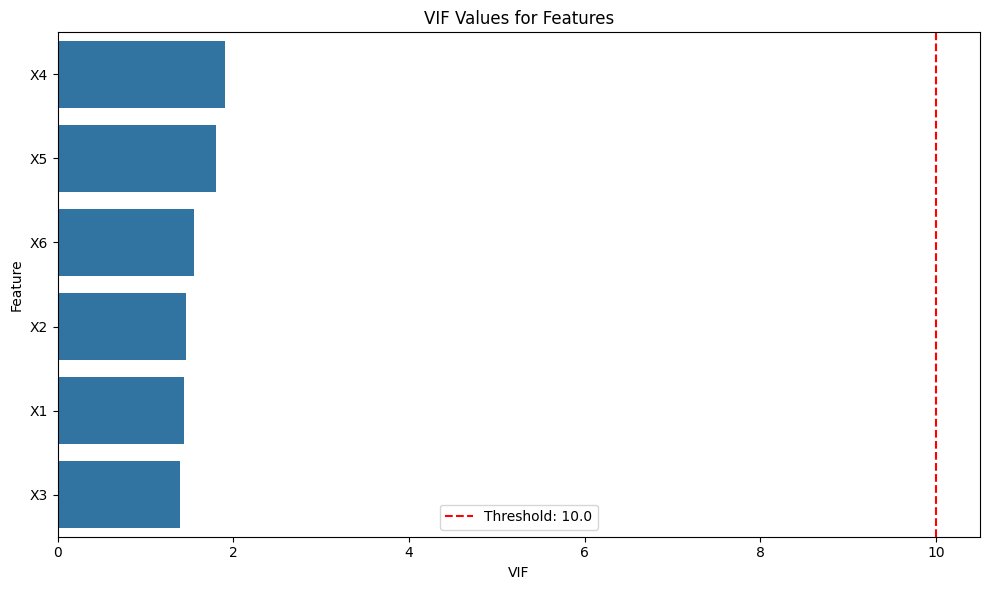


Final VIF values after removing high-VIF features:
   Feature       VIF
3      X4  1.907826
4      X5  1.803530
5      X6  1.552842
1      X2  1.459775
0      X1  1.434481
2      X3  1.396807


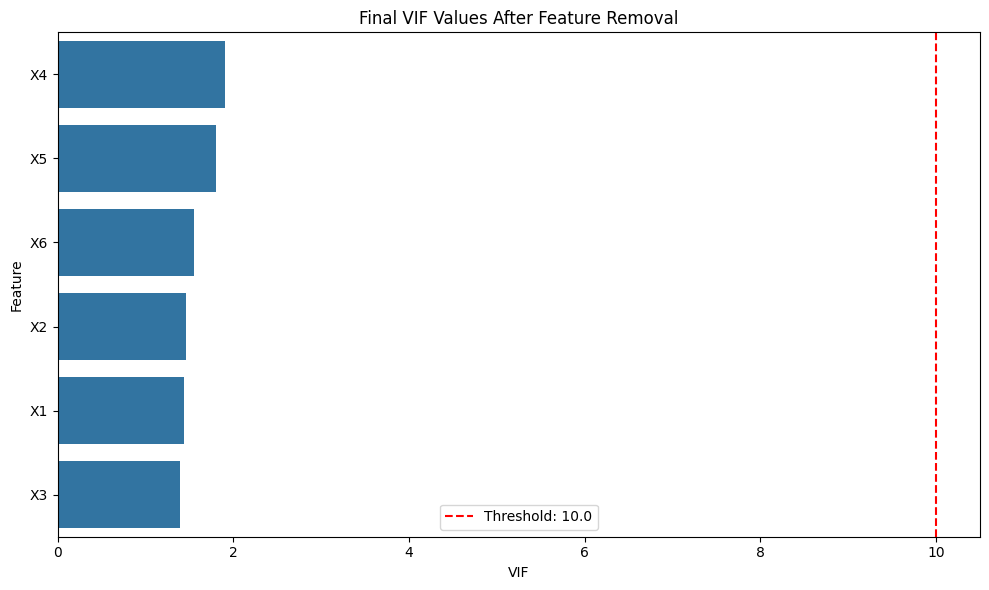


Removed 0 features: []
Remaining features: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6']


In [8]:
X = handle_multicollinearity_vif(X.select_dtypes(include=['int64', 'float64']), threshold=10.0)